<a href="https://colab.research.google.com/github/Aayushktyagi/Gray-to-RGB/blob/master/image_Colourise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(210, 224, 224, 3) (210, 224, 224, 1)
RGB data:(210, 224, 224, 3),Gray data:(210, 224, 224, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 56, 56, 128)       73856     
_______________________________________________

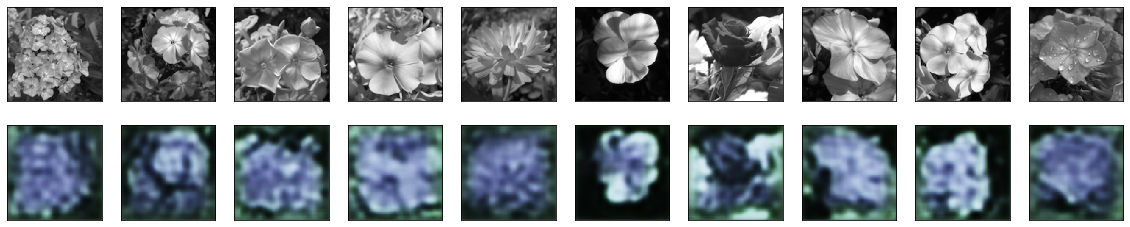

In [21]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt

#load datset
def getData(filepath):
  rgb_list = []
  gray_list = []
  # filepath = '/media/aayush/Work/Work/Github/Generative_models/Autoencoders/ImageColourization/flower-color-images'
  file_path = glob.glob(os.path.join(filepath,'*.png'))


  for img_path  in file_path:
    rgb_img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    rgb_img = cv2.resize(rgb_img,(224,224))
    gray_img = cv2.resize(gray_img,(224,224))
    rgb_list.append(rgb_img)
    gray_list.append(gray_img)

  rgb_images = np.stack(rgb_list,axis=0)
  gray_images = np.stack(gray_list,axis=0)
  gray_images = np.reshape(gray_images,(len(gray_images),224,224,1))

  print(np.shape(rgb_images),np.shape(gray_images))
  return rgb_images , gray_images


import tensorflow as tf
from tensorflow.keras.layers import Input , Conv2D , UpSampling2D,MaxPooling2D
from tensorflow.keras.models import Model

class Autoencoder(object):
    '''
    Convolutional Autoencoder to convert gray scale imagas to RGB
    '''

    def __init__(self):

        #Encoder
        input_layer = Input(shape=(224,224,1))
        encoding_conv_layer1 = Conv2D(32,(3,3),activation = 'relu',padding = 'same')(input_layer)
        encoding_conv_layer1 = MaxPooling2D((2,2),padding = 'same')(encoding_conv_layer1)
        encoding_conv_layer2 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(encoding_conv_layer1)
        encoding_conv_layer2 = MaxPooling2D((2,2),padding = 'same')(encoding_conv_layer2)
        encoding_conv_layer3 = Conv2D(128,(3,3),activation= 'relu',padding='same')(encoding_conv_layer2)
        encoding_conv_layer3 = MaxPooling2D((2,2) , padding = 'same')(encoding_conv_layer3)
        encoding_conv_layer4 = Conv2D(256 , (3,3),activation = 'relu',padding = 'same')(encoding_conv_layer3)
        latent_vector = MaxPooling2D((2,2),padding = 'same')(encoding_conv_layer4)

        #decoder
        decoding_conv_layer1 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(latent_vector)
        decoding_conv_layer1 = UpSampling2D((2,2))(decoding_conv_layer1)
        decoding_conv_layer2 = Conv2D(64,(3,3),activation ='relu',padding = 'same')(decoding_conv_layer1)
        decoding_conv_layer2 = UpSampling2D((2,2))(decoding_conv_layer2)
        decoding_conv_layer3 = Conv2D(32,(3,3),activation = 'relu',padding ='same')(decoding_conv_layer2)
        decoding_conv_layer3 = UpSampling2D((2,2))(decoding_conv_layer3)
        decoding_conv_layer4 = Conv2D(8,(3,3),activation = 'relu',padding = 'same')(decoding_conv_layer3)
        decoding_conv_layer4 = UpSampling2D((2,2))(decoding_conv_layer4)
        #decoding_conv_layer5 = Conv2D(4,(3,3),activation = 'relu',padding = 'same')(decoding_conv_layer4)
        #decoding_conv_layer5 = UpSampling2D((2,2))(decoding_conv_layer5)
        output_layer = Conv2D(3,(3,3),activation = 'sigmoid',padding = 'same')(decoding_conv_layer4)
        
        #loss_function=tf.reduce_mean(tf.squared_difference(output_layer , ))
        self._model = Model(input_layer , output_layer)
        self._model.compile(optimizer = 'sgd' , loss = 'mean_squared_error')
        self._model.summary()

    def train(self, input_train,output_train,input_test,output_test,batch_size,epochs):
        
        self._model.fit(input_train,
                        output_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data = (input_test,
                                            output_test))

    def getDecodedImage(self,test_image):
        decoded_image = self._model.predict(test_image)
        return decoded_image

filepath = "drive/My Drive/Dataset/flower_images"
rgb_data , gray_data = getData(filepath)
#normalize data 
rgb_data = rgb_data / 255.0
gray_data =gray_data / 255.0
print("RGB data:{},Gray data:{}".format(np.shape(rgb_data),np.shape(gray_data)))

#train models
autoencoder = Autoencoder()
autoencoder.train(gray_data ,rgb_data, gray_data,rgb_data , 32,3000)
decoder_image = autoencoder.getDecodedImage(gray_data)
print(np.shape(decoder_image))

#visualization
plt.figure(figsize = (20,4))

for i in range(10):
    #orignal
    subplot = plt.subplot(2,10,i+1)
    plt.imshow(gray_data[i].reshape(224,224))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
    #reconstructed image
    subplot = plt.subplot(2,10,i+11)
    plt.imshow(decoder_image[i].reshape(224,224,3))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
plt.show()